---
title: Scandal analysis on Chipotle
space: INTFEL
parent: Yihan ZHONG
comment: Identify potential patterns or trends that can contribute to a better understanding of a scandal
---

## 0. Packages and functions

In [1]:
import pandas as pd
# en python:
import os
os.environ["https_proxy"] = "http://proxy.fr.cfm.fr:6060"
import numpy as np
import torch
import torch.nn as nn
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModelForSequenceClassification #, Trainer, TrainingArguments, DataCollatorWithPadding, default_data_collator
from datasets import Dataset
from torch.utils.data import DataLoader
import pandas as pd 
import numpy as np 
import faiss 
import tqdm 
import multiprocessing 
import dill as pickle
import datetime
import copy
import re
import torch.nn.functional as F
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

/home/yzhong/conda/envs/yihan_gpu/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Transformer configuration

In [3]:
import json
# read the config file into a dictionary
with open("/home/yzhong/notebooks/getting_started/config_transformer.json", "r") as f:
    config_ = json.load(f)

print(config_)

{'TRANSLATION_MODEL': 'Helsinki-NLP/opus-mt-zh-en', 'SENTENCE_TRANSFORMER': 'all-MiniLM-L6-v2', 'TRANSLATION_MODEL_ADVANCE': 'alirezamsh/small100', 'model_dir': '/opt/tmp/yzhong/models/'}


Functions for calculating sentence embeddings

In [4]:
def compute_length(batch, text='headline'):
    return {
        'length': [len(item) for item in batch[text]]
    }
def sentence_embeddings(batch, model,text='translation'):
    with torch.no_grad():
        embeddings = model.encode(batch[text])
    return {'embeddings': embeddings}

Function for finding the duplicated headlines

In [5]:
def find_duplicates(df):
    df_copy = df.copy()
    df_copy['headline_lower'] = df_copy['headline'].str.lower()  # Convert headlines to lowercase
    regex_pattern = r'correct:|\(\d+\)\.|update\d+|\(correct\)'
    duplicates = df_copy[df_copy.duplicated(subset='headline_lower', keep='first') | df_copy['headline_lower'].str.contains(regex_pattern)]
    df_copy['duplicate'] = 0  # Initialize 'duplicates' column with 0 for all rows
    df_copy.loc[duplicates.index, 'duplicate'] = 1  # Set 'duplicates' flag to 1 for rows in the list of duplicates
    return df_copy


In [6]:
def is_all_uppercase(headline):
    '''
    The function will return True if the headline contains only uppercase alphabetic characters, with no non-alphabet characters.
    '''
    # Remove any non-alphabet characters from the headline
    headline_alpha = re.sub(r'[^A-Za-z]', '', headline)
    return headline_alpha.isupper()

In [2]:
def get_volume(df):
    '''
    Calculates the volume statistics for a given dataframe.

    Args:
        df : Input dataframe containing the date

    Returns:
        pd.DataFrame: Output dataframe with volume statistics on number of headlines, number of duplicates and number of news in capital

    '''

    # Convert the 'date' column to datetime format
    df = df.assign(date=pd.to_datetime(df['date']))

    # Extract the 'day' component from the 'date' column as a string in the format '%Y-%m-%d'
    df = df.assign(day=df['date'].dt.strftime('%Y-%m-%d'))

    # Group the dataframe by 'date' and calculate various aggregates
    df_volume = df.groupby('date').agg(
        Count=('date', 'size'),          # Number of occurrences for each date
        duplicate=('duplicate', 'sum'),  # Sum of the 'duplicate' column for each date
        capital=('capital', 'sum')       # Sum of the 'capital' column for each date
    ).reset_index().set_index('date')

    return df_volume


In [3]:
def average_embedding(df):
    '''
    Calculates the average embedding for each date in the given dataframe for all the headline.

    '''

    # Filter the dataframe to include only rows where 'duplicate' column is 0
    filtered_df = df.loc[df['duplicate'] == 0]

    # Group the filtered dataframe by 'date' and calculate the mean of 'embeddings' for each date
    df_average_embedding = filtered_df.groupby('date')['embeddings'].apply(lambda x: np.mean(x, axis=0))

    # Reset the index and rename the column to 'embedding_average'
    df_average_embedding = df_average_embedding.reset_index().rename(columns={'embeddings': 'embedding_average'})

    return df_average_embedding


In [4]:
def cosinus_similarity (emb1, emb2):
    '''
    Calculate the cosine similarity for two embeddings
    
    '''
    emb1=torch.tensor(emb1).unsqueeze(0)
    emb2=torch.tensor(emb2).unsqueeze(0)
# cosine similarity = normalize the vectors & multiply
    C = F.normalize(emb1) @ F.normalize(emb2).t()
    return round(C.item(), 2)

In [5]:
def aggregate_date_volume(df, year):
    '''
    Aggregates the news volume and duplicated news for a specific year in the given dataframe.

    '''

    # Filter the dataframe to include only rows where the year matches the specified year
    filtered_df = df[df['date'].dt.year == year]

    # Aggregate the news volume and duplicated news
    df_volume_year = filtered_df.assign(date=pd.to_datetime(filtered_df['date']),
                                    day=filtered_df['date'].dt.strftime('%Y-%m-%d')) \
                            .groupby('date').agg(Count=('date', 'size'), duplicate=('duplicate', 'sum')) \
                            .reset_index().set_index('date')

    return df_volume_year


In [11]:
def find_peak(df,col,year,distance=10):
    '''
    Finds the peak indices in a specified column of a dataframe for a given year.

    Args:
        df : Input dataframe with the index set as datetime type.
        col (str): Name of the column to analyze for peak detection.
        year (int): Year to focus the analysis on.
        distance (int): Minimum number of indices between peaks.

    Returns:
        np.ndarray: Array containing the indices of the identified peaks.

    '''
    
    'input dataframe should be set index as datetime type'

    data = df[col].to_numpy()

    # Use scipy's find_peaks to detect peak indices
    peak_indices, _ = find_peaks(data, distance=5)
    # Plot the time series with identified peaks
    plt.plot(df.index, data, label=col)
    plt.scatter(df.index[peak_indices], data[peak_indices], color='red', label='Peaks')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.title(f'Peak Detection for {col} in {year}')
    plt.legend()
    plt.show()
    return peak_indices

In [12]:
def timeseries_boolean(df_volume,df_embedding,index_volume, index_cosine):
    '''
    Creates a boolean time series plot for volume peaks and cosine similarity peaks.

    Args:
        df_volume (pd.DataFrame): DataFrame containing volume information.
        df_embedding (pd.DataFrame): DataFrame containing embedding information (not used in the code snippet).
        index_volume (list): List of indices representing volume peaks.
        index_cosine (list): List of indices representing cosine similarity peaks.

    Returns:
        None

    '''
    volume_peak_series = pd.Series(False, index=df_volume.index)
    volume_peak_series.loc[index_volume] = True
    cosine_peak_series = pd.Series(False, index=df_volume.index)
    cosine_peak_series.loc[index_cosine] = True

    # Plot the boolean time series for volume peaks
    plt.figure(figsize=(10, 5))
    plt.plot(df_volume.index, volume_peak_series, label='Volume Peaks', color='blue')

    # Plot the boolean time series for cosine similarity peaks
    plt.plot(df_volume.index, cosine_peak_series, label='Cosine Similarity Peaks', color='red')

    # Customize the plot
    plt.xlabel('Date')
    plt.ylabel('Peak Indicator')
    plt.title('Boolean Time Series Plot for Volume and Cosine Similarity Peaks')
    plt.legend()

    # Display the plot
    plt.show()

In [13]:
def analyse_year_peak (df,df_e,year):
    df_year_volume=aggregate_date_volume(df,year)
    df_year_volume.plot()
    volume_peak_indices=find_peak(df_year_volume,'Count',year,distance=1)
    volume_peak_date=df_year_volume.index[volume_peak_indices]
   
    df_e_year=df_e[df_e.index.year == year]

    cosine_peak_indice=find_peak(df_e_year,'cosine_similarity',year,distance=1)
    cosine_peak_date=df_e_year.index[cosine_peak_indice]

    timeseries_boolean(df_year_volume,df_e_year,volume_peak_date, cosine_peak_date)
  
    return volume_peak_date,cosine_peak_date

In [14]:
def plot_peak_volume(df_rolling_volume, df2):
    '''
    Plots the normalized news volume over earning days.

    Args:
        df_rolling_volume (pd.DataFrame): DataFrame containing rolling volume information.
        df2 (pd.DataFrame): DataFrame containing additional information.

    Returns:
        None

    '''

    c = 'special_day'

    # Calculate the median of news volume multiplied by the shifted 'special_day' values for different lags
    data = pd.Series({i: df_rolling_volume['Count'].mul(df2[c].shift(i)).median() for i in range(-5, 5)})

    # Plot the normalized news volume over earning days
    data.plot(label='Total News Volumes')

    # Calculate the median of duplicated news volume multiplied by the shifted 'special_day' values for different lags
    data2 = pd.Series({i: df_rolling_volume['duplicate'].mul(df2[c].shift(i)).median() for i in range(-5, 5)})

    # Plot the normalized duplicated news volume over earning days
    data2.plot(label='Duplicated News Volumes')

    # Customize the plot
    plt.title('Normalized News Volume over Earning Days')
    plt.legend()
    plt.show()


def plot_peak_cosine(df_rolling_cosine, df2, col='cosine_similarity'):
    '''
    Plots the cosine similarity over earning days.

    Args:
        df_rolling_cosine (pd.DataFrame): DataFrame containing rolling cosine similarity information.
        df2 (pd.DataFrame): DataFrame containing additional information.
        col (str): Column name for cosine similarity (default: 'cosine_similarity')

    Returns:
        None

    '''

    c = 'special_day'

    # Calculate the median of cosine similarity multiplied by the shifted 'special_day' values for different lags
    data = pd.Series({i: df_rolling_cosine[col].mul(df2[c].shift(i)).median() for i in range(-5, 5)})

    # Plot the cosine similarity over earning days
    data.plot()

    # Customize the plot
    plt.title(f'{col} over Earning Days')
    plt.show()


In [15]:
def identify_market_on_close(headline):
    pattern = r'^(MARKET ON CLOSE|OPENING DELAY:).*'
    return re.match(pattern, headline) is not None

## remove balance sheet 

In [45]:
def filter_balance_sheet(df, col='headline'):
    
    # Define the key words for filtering balance sheet news
    pattern = r"(?=.*?\b(?:CAPEX|CAPITAL|EPS|NET|INCOME|REV|INC|LOSS|BILLINGS|ADJ|SALES|EQUITY|ENTITLEMENT|COSTS|REVENUE|ADJUSTED|PROFIT|EST|EARNINGS|INCOME|CASH|EPA)\b)"

    # Apply filter conditions and add flag column
    df['balance_sheet'] = (
        df[col].apply(lambda headline: bool(re.search(pattern, headline))) # Check if headline contains the key words,(True if there is a match, False otherwise).
        #excluded headlines that contains only 1Q, 2Q, 3Q, 4Q but no other digits number surrended by Q 
        & ~df[col].apply(lambda headline: bool(re.match(r"^\D*\b\dQ\b\D*$", headline)))
        # exclude headlines that only contains year and no other digits number surronded  year range (1999-9999)
        & ~df[col].apply(lambda headline: bool(re.match(r"^\D*(?:(19|[2-9][0-9])\d{2})\D*$", headline)))
        #make sure that the sentence contains digit
        & df[col].str.contains(r'\d') 
    ).astype(int)

    return df

In [16]:
from pathlib import Path
path = Path('/mnt/research-live/equity/reference/equity_data/sa_research/current/')
news_volume_ =pd.read_parquet(path /'CFM_AMER/equity_data/eqt_bb_news_volumes.parquet')

In [24]:
news_volume = news_volume_.rename(columns={'daclose': 'BDATE'}) \
                         .groupby(['BDATE', 'eqt_code'])['total_count'] \
                         .mean() \
                         .unstack()

In [25]:
# Normalize the news_volume DataFrame by dividing each element by its corresponding rolling mean
df = news_volume.pipe(
    lambda x: x.div(
        x.rolling(window=126, min_periods=42).mean()  # Calculate the rolling mean for each element
    )
)[['CMG_UN']]

In [37]:
df=pd.read_parquet('/mnt/research-live/user/yzhong/Single_level_stock/Single_stock_news_2015.parquet')

In [5]:
df['id']=df.index

In [8]:
MODEL_ID = config_['SENTENCE_TRANSFORMER']
model = SentenceTransformer(MODEL_ID,device='cuda',cache_folder=config_['model_dir'] )
# Use the map method to apply the mapping function to the dataset in batches
batch_size =256*4

In [9]:
ds_t = Dataset.from_dict(df)
cols_to_remove = ds_t.column_names
cols_to_remove.remove("headline")
cols_to_remove.remove("id")
ds_t1=ds_t.remove_columns(cols_to_remove)

In [10]:
ds_t1 = ds_t1.map(lambda x: compute_length(x, text='headline'), batched=True).sort('length', reverse=True)
ds_t1 = ds_t1.map(lambda x: sentence_embeddings(x ,model, text='headline'), batched=True, batch_size=batch_size).sort('id')

Parameter 'function'=<function <lambda> at 0x7f3c09ce7d30> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


In [11]:
df['embeddings']=ds_t1['embeddings']

In [18]:
# Load embeddings from the pickle file
with open('/mnt/research-live/user/yzhong/Single_level_stock/embeddings_2015.pkl', 'rb') as f:
    embeddings = pickle.load(f)

In [121]:
with open('/mnt/research-live/user/yzhong/CMG_2015.txt', 'w') as f:
    for row in df_chipotle.itertuples():
        f.write(str(row.last_update) + '\n')
        f.write(f'{str(row.headline)}' + '\n')

In [20]:
df.to_parquet('/mnt/research-live/user/yzhong/Single_level_stock/Single_stock_news_2015.parquet')

In [38]:
df_chipotle=df[df['eqt_code']=='CMG_UN']

In [39]:
len(df_chipotle)

241

In [20]:
ead_ = pd.read_parquet(path /'CFM_AMER/equity_data/eqt_earning_announcement_dates.parquet') # date for earnings

In [21]:
# Convert the rows into columns for the eqt_code earning date
ead = ead_.assign(one=1) \
          .rename(columns={'earning_date': 'BDATE'}) \
          .set_index(['BDATE', 'eqt_code']) \
          .squeeze() \
          .unstack()

In [26]:
df2 =ead.reindex_like(df)

In [28]:
earning_days=df2.dropna().index.to_list()

In [40]:

# Convert earning_days to the same datetime format as the 'date' column
earning_days = [pd.to_datetime(date).date() for date in earning_days]

# Create a boolean mask to identify the rows to be dropped
mask = df_chipotle['date'].isin(earning_days)

# Filter the DataFrame and drop the rows
df_chipotle = df_chipotle[~mask]


In [41]:
len(df_chipotle)

238

In [42]:
def dataframe_preprocess (df_chipotle):
    df_chipotle['date']=pd.to_datetime(df_chipotle['date'])
    df_chipotle = df_chipotle[~df_chipotle['headline'].apply(identify_market_on_close)].reset_index(drop=True)
    df_chipotle['embeddings'] = df_chipotle['embeddings'].apply(lambda x: np.array(x))
    df_chipotle=find_duplicates(df_chipotle)
    df_chipotle['capital'] = df_chipotle['headline'].apply(is_all_uppercase).astype(int)
    df_chipotle=filter_balance_sheet(df_chipotle, col='headline')
    df_chipotle=df_chipotle[df_chipotle['balance_sheet']==0]
    return df_chipotle



In [46]:
df_chipotle=dataframe_preprocess (df_chipotle)

In [47]:
len(df_chipotle)

187

In [48]:
df_chipotle_small=df_chipotle[df_chipotle['capital']==0]

In [49]:
def dataframe_analyse(df_chipotle):
    volume_CMG=get_volume(df_chipotle)
    df_average_embedding=average_embedding (df_chipotle)
    df_average_embedding.set_index('date', inplace=True)
    volume_CMG = volume_CMG.reindex(index=df_average_embedding.index).dropna()
    resampled_df = df_average_embedding['embedding_average'].apply(pd.Series).rolling(window=7,min_periods=2).mean()
    df_average_embedding['rolling_embedding_average'] = resampled_df.apply(lambda row: np.array(row.values.tolist()), axis=1)
    df_average_embedding['cosine_similarity'] = df_average_embedding.apply(
    lambda row: cosinus_similarity(row['embedding_average'], df_average_embedding.iloc[df_average_embedding.index.get_loc(row.name) - 1]['embedding_average']) if df_average_embedding.index.get_loc(row.name) > 0 else np.nan,
    axis=1
)
    df_average_embedding['rolling_cosine_similarity'] = df_average_embedding.apply(
    lambda row: cosinus_similarity(row['embedding_average'], df_average_embedding.iloc[df_average_embedding.index.get_loc(row.name) - 1]['rolling_embedding_average']) if df_average_embedding.index.get_loc(row.name) > 0 else np.nan,
    axis=1
)
    columns_to_average = ['cosine_similarity', 'rolling_cosine_similarity']

    df_rolling_cosine = df_average_embedding[columns_to_average].pipe(
    lambda x: x.div(
        x.rolling(window=10, min_periods=2).mean()  # Calculate the rolling mean for each column
    )
)
    df_rolling_volume=volume_CMG.pipe(
    lambda x: x.div(
        x.rolling(window=30, min_periods=10).mean()  # Calculate the rolling mean for each date
    )
)
    return volume_CMG, df_average_embedding,df_rolling_cosine,df_rolling_volume


In [64]:
volume_CMG, df_average_embedding,df_rolling_cosine,df_rolling_volume=dataframe_analyse(df_chipotle)

In [90]:
volume_CMG_small, df_average_embedding_small, df_rolling_cosine_small,df_rolling_volume_small=dataframe_preprocess(df_chipotle_small)

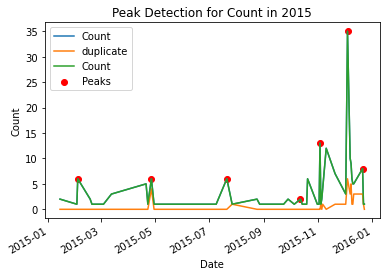

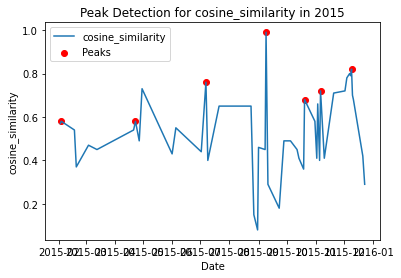

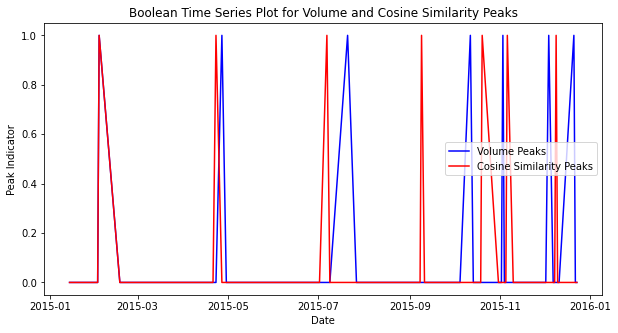

In [65]:
volume_peak_date,cosine_peak_date=analyse_year_peak(df_chipotle,df_average_embedding,year=2015)

In [52]:
def find_peaks_low(df, col, threshold=0.5, distance=5):
    """
    Find indices of peaks and lows in a time series based on a threshold value.
    
    Args:
        df (DataFrame): Input DataFrame with datetime index.
        col (str): Name of the column containing the time series data.
        threshold (float): Threshold value for identifying lows.
        distance (int): Minimum distance between peaks or lows.
    
    Returns:
        peak_indices (array): Indices of detected peaks.
        low_indices (array): Indices of detected lows.
    """
    data = df[col].to_numpy()
    
    # Use scipy's find_peaks to detect peak indices
    peak_indices, _ = find_peaks(data, distance=distance)
    
    # Find indices where the data is lower than the threshold value
    low_indices = np.where(data < threshold)[0]
    
    # Plot the time series with identified peaks and lows
    plt.plot(df.index, data, label=col)
    plt.scatter(df.index[peak_indices], data[peak_indices], color='red', label='Peaks')
    plt.scatter(df.index[low_indices], data[low_indices], color='green', label='Lows')
    plt.xlabel('Date')
    plt.ylabel(col)
    plt.title('Peak and Low Detection')
    plt.legend()
    plt.show()
    
    return peak_indices, low_indices

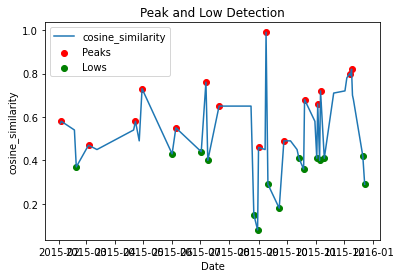

In [66]:
cosine_peak_indices_, cosine_low_indices_=find_peaks_low(df_average_embedding, 'cosine_similarity', threshold=0.45, distance=1)

In [ ]:
cosine_peak_indices_, cosine_low_indices_=find_peaks_low(df_average_embedding_small, 'cosine_similarity', threshold=0.45, distance=1)

In [68]:
df_average_embedding.index[cosine_peak_indices_]

DatetimeIndex(['2015-02-03', '2015-03-04', '2015-04-23', '2015-04-30',
               '2015-06-05', '2015-07-07', '2015-07-21', '2015-09-01',
               '2015-09-09', '2015-09-28', '2015-10-20', '2015-11-03',
               '2015-11-06', '2015-12-07', '2015-12-09'],
              dtype='datetime64[ns]', name='date', freq=None)

In [69]:
df_average_embedding.index[cosine_low_indices_]

DatetimeIndex(['2015-02-19', '2015-06-01', '2015-07-02', '2015-07-09',
               '2015-08-27', '2015-08-31', '2015-09-11', '2015-09-23',
               '2015-10-14', '2015-10-19', '2015-11-02', '2015-11-05',
               '2015-11-10', '2015-12-21', '2015-12-23'],
              dtype='datetime64[ns]', name='date', freq=None)

In [70]:
volume_peak_date

DatetimeIndex(['2015-02-03', '2015-04-27', '2015-07-21', '2015-10-12',
               '2015-11-03', '2015-12-04', '2015-12-21'],
              dtype='datetime64[ns]', name='date', freq=None)

In [71]:
# Create a new dataframe with the same index as volume_CMG
df2 = pd.DataFrame(index=volume_CMG.index)

# Add the 'special_day' column to df2
df2['special_day'] = np.nan

In [109]:
df2 = pd.DataFrame(index=volume_CMG_small.index)

# Add the 'special_day' column to df2
df2['special_day'] = np.nan

In [72]:
df2.loc['2015-11-02', 'special_day'] = 1

In [ ]:
df_average_embedding_small.loc['2015-11-02']

In [73]:
df_average_embedding.loc['2015-11-02']

embedding_average            [-0.05370420217514038, -0.09389886260032654, -...
rolling_embedding_average    [-0.01597702816971357, -0.023741811646946838, ...
cosine_similarity                                                         0.41
rolling_cosine_similarity                                                 0.61
Name: 2015-11-02 00:00:00, dtype: object

In [ ]:
columns_to_average = ['cosine_similarity', 'rolling_cosine_similarity']

df_rolling_cosine = df_average_embedding[columns_to_average].pipe(
    lambda x: x.div(
        x.rolling(window=10, min_periods=2).mean()  # Calculate the rolling mean for each column
    )
)
df_rolling_volume=volume_CMG_small.pipe(
    lambda x: x.div(
        x.rolling(window=30, min_periods=10).mean()  # Calculate the rolling mean for each date
    )
)

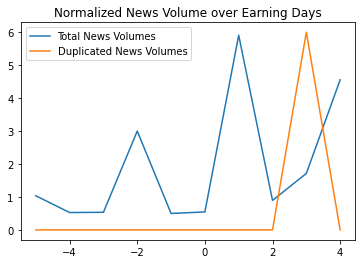

In [75]:
plot_peak_volume(df_rolling_volume, df2)

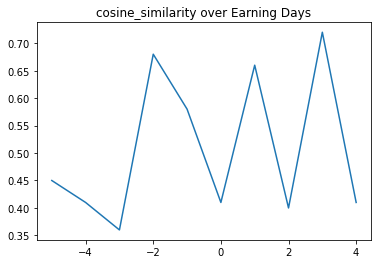

In [76]:
plot_peak_cosine(df_average_embedding,df2,col='cosine_similarity')

Date of scandle: 07/12/2015